# Counting DL and DLT histories
### Cedric Chauve, 29/04/2019

### Abstract.
This notebook contains the code used to analyse our experimental results and generate figures that are presented in the paper. It also includes additional figures not presented in the paper.

In [87]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import math
from trees import *

## Introduction

In this notebook, we consider 4 *models*: unranked DL (*UDL*), ranked Dl (*RDL*), unranked DLT (*UDLT*) and ranked DLT (*RDLT*). For each model, we generated $100$ species tree of size $k$ as follows: the caterpillar, a balanced binary tree, and the remaining $98$ species trees are generated at random under the uniform distribution, using the RANRUT algorithm as described in <a href="https://doi.org/10.1016/B978-0-12-519260-6.50035-8">Random Unlabeled Rooted Trees (RANRUT)</a>. 

Note that in this setting, for small values of $k$, some species trees are generated several times. Moreover, to do experiments in the two ranked models, for each species tree, we generated $10$ random rankings, again chosen under the uniform distribution using the algorithm for the random generation of linear extensions described in <a href="https://doi.org/10.1007/s00026-018-0371-7">On the Number of Unary-Binary Tree-Like Structures with Restrictions on the Unary Height</a>. 

Finally for each input (to be understood as a species tree $S$ of size $k$, together with a ranking if we are in a ranked model), we counted the number of histories (in the chosen model) of size $n$. Our range parameter is $k \in [3,25]$ and $n\in [1,50]$.

Moreover, for each tree, in the unranked DL model, we computed the exact value of the exponential growth factor of the asymptptics of the number of histories.

In [2]:
# Parameters
# Number of species trees per size
NB_S_TREES    = 100
S_TREES_INDEX = [i for i in range(0,NB_S_TREES)]
# Evolutionary models
EVOL_MODELS = [('U','DL'),('U','DLT'),('R','DL'),('R','DLT')]
MODEL2LEGEND = {'U_DL': 'UDL model',
                'U_DLT': 'UDLT model',
                'R_DL': 'RDL model',
                'R_DLT': 'RDLT model'}
# Species tree sizes
K_MIN = 3
K_MAX = 25
K_LIST = [k for k in range(K_MIN,K_MAX+1)]
# Histories sizes
N_MIN = 1
N_MAX = 50
N_LIST = [n for n in range(N_MIN,N_MAX+1)]
# Paths to results
PREFIX_UNRANKED    = '../exp/unranked/results_unranked'
PREFIX_RANKED      = '../exp/ranked/results_ranked'
PREFIX_ASYMPTOTICS = '../exp/asymptotics/asymptotics_DL'
PREFIX_SCORES      = '../exp/sampling/samples'
PREFIX_TREES       = '../exp/trees/trees_unranked'
# Rankings
R_MAX  = 10
R_LIST = [r for r in range(1,R_MAX+1)]
# Subset of the parameter space for more readable figures
K_LIST_REDUCED = [10,15,20,25]
N_LIST_REDUCED = [10,20,30,40,50]

In [3]:
# Reading the unranked trees
# Dictionary structure recording, for each value of k, the tree structures indexed by their ID 
TREES_dict = {k:{} for k in K_LIST}

def read_trees_file(fileName):
    treesFile = open(fileName,'r').readlines()
    for row in treesFile:
        if row[0] != '#':
            row1 = row.rstrip().split('\t')
            k = int(row1[0])
            treeIndex = int(row1[1])
            treeNewick = row1[2]
            tree = newick2Tree(treeNewick)
            labelTree(tree)
            TREES_dict[k][treeIndex] = tree
for k in K_LIST:
    read_trees_file(PREFIX_TREES+'_'+str(k))

In [4]:
# Reading the exact counting results
# Format: RESULTS_ALL[evol_model][s][n][tree_index] is 
# the list of the number of histories of size n for tree tree_index of size s in model evol_model 
# the list is of size 1 if the tree is unranked

RESULTS_aux = {m:{k:{n:{t:[] for t in S_TREES_INDEX} for n in N_LIST}  for k in K_LIST} for m in EVOL_MODELS}
    
def read_counting_file(fileName,k):
    with gzip.open(fileName, 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0]!='#':
                model     = (row[2],row[3])
                treeIndex = int(row[1])
                row5      = row[5].split()
                for n in N_LIST:
                    RESULTS_aux[model][k][n][treeIndex].append(int(row5[n-1]))
    
for k in K_LIST:
    read_counting_file(PREFIX_UNRANKED+'_'+str(k)+'.gz',k)
    read_counting_file(PREFIX_RANKED+'_'+str(k)+'.gz',k)

# Counting are stored ina data frame indexed by a triple (model,k,n) and storing the list of 1 (resp. 10) counting results
# in the unranked (resp. ranked) model.
RESULTS_COUNTING = pd.DataFrame.from_dict({(m,k,n): RESULTS_aux[m][k][n]
                                            for m in RESULTS_aux.keys() 
                                            for k in RESULTS_aux[m].keys()
                                            for n in RESULTS_aux[m][k].keys()},
                                            orient='index')

In [5]:
# Reading the exact asymptotics (growth factor) results for the model UDL

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    dataAsympt = open(PREFIX_ASYMPTOTICS+'_'+str(k)).readlines()
    for row in dataAsympt:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            asymptotics =  float(row1[3])
            RESULTS_aux[k][treeIndex] = asymptotics

# The results are stored in a dataframe indexed by the tree size (rows) and the tree ID (columns).
RESULTS_ASYMPTOTICS_UDL = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

## Asymptotics in the unranked DL model

We first look at the simplest model, the U-DL model, where we can obtain theortical asymptotics estimates. Here we assume that for a given species tree $S$ and a given history size $n$, we have
$$h_S(n) \simeq \gamma_S \frac{\alpha_S^n}{n^{3/2}}\left(1+O\left(\frac{1}{n}\right)\right).$$
We call $\alpha_S$ the *growth factor* and $\gamma_S$ the *constant*.

We first look at the exact growth factor computed using analytic combinatorics techniques. Next we provide support for Conjecture 4.1. about the species tree topologies leading the the largest and smallest growth factors.

<Figure size 432x288 with 0 Axes>

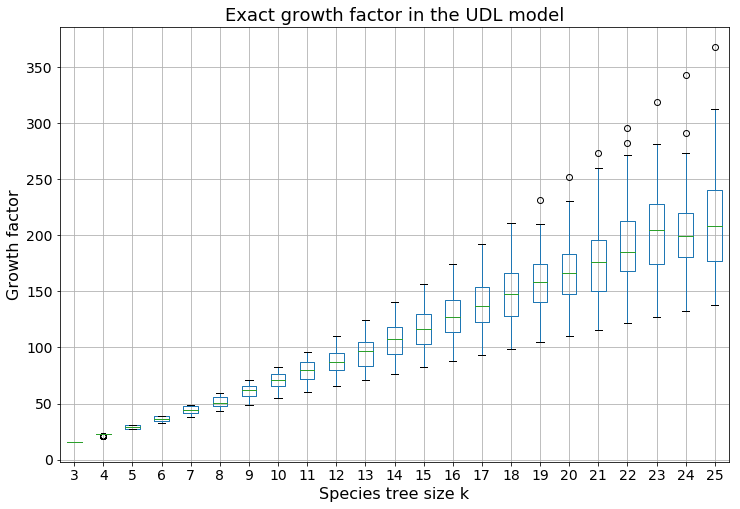

In [6]:
plt.figure()
ax_asympt1 = RESULTS_ASYMPTOTICS_UDL.transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Exact growth factor in the UDL model', fontsize=14)
ax_asympt1.title.set_size(18)
ax_asympt1.set_ylabel('Growth factor', fontsize=16)
ax_asympt1.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/computed_growth_factor_U_DL.png')
plt.show()

We can observe that the minimum and median value seem to grow linearly, while the max value seems to grow non-linearly. Note however that this is over a sample of species tree so the results might not be extremely robust for larger values of $k$. 

We are now looking at the species tree that leads to extreme growth factor, toward providing support for Conjecture 4.1 of the paper that we restate now.

*Conjecture 4.1.* For a given $k$, and $n$ large enough, the unranked species tree of size $k$ having the largest number of DL-histories of size $n$ is the caterpillar tree; moreover the exponential growth factor of the number of histories for a caterpillar of size $k$ grows quadratically as a function of $k$. Species trees having the smallest number of DL-histories are balanced species trees of size $k$; moreover the exponential growth factor of the number of histories for a balanced tree of size $k$ grows linearly as a function of $k$.

In [7]:
# Checking the trees with max growth rates are caterpillar and the trees with min growth rate are balanced

print('Checking, for each value of k, if the species tree with maximum (resp. minimum) growth factor is a caterpillar (resp. balanced).')

def check_min_max_growth_factor(df):
    df_min = df.idxmin(axis=1)
    df_max = df.idxmax(axis=1)
    for k in K_LIST:
        if checkCaterpillar(TREES_dict[k][df_max[k]]):
            print('k = '+str(k)+': the species tree with max. growth constant is the caterpillar')
        if checkBalanced(TREES_dict[k][df_min[k]]):
            print('k = '+str(k)+': the species tree with min. growth constant is balanced')
    return((df_min,df_max))
(UDL_MIN_GF,UDL_MAX_GF) = check_min_max_growth_factor(RESULTS_ASYMPTOTICS_UDL)

Checking, for each value of k, if the species tree with maximum (resp. minimum) growth factor is a caterpillar (resp. balanced).
k = 3: the species tree with max. growth constant is the caterpillar
k = 3: the species tree with min. growth constant is balanced
k = 4: the species tree with max. growth constant is the caterpillar
k = 4: the species tree with min. growth constant is balanced
k = 5: the species tree with max. growth constant is the caterpillar
k = 5: the species tree with min. growth constant is balanced
k = 6: the species tree with max. growth constant is the caterpillar
k = 6: the species tree with min. growth constant is balanced
k = 7: the species tree with max. growth constant is the caterpillar
k = 7: the species tree with min. growth constant is balanced
k = 8: the species tree with max. growth constant is the caterpillar
k = 8: the species tree with min. growth constant is balanced
k = 9: the species tree with max. growth constant is the caterpillar
k = 9: the speci

We look below at the growth factor for the caterpillar and balanced trees, to investigate how it does grow as a function of $k$.

For the minimum growth rate, we fitted a line to the growth rates for values of $k$ for which the tree with minimum growth rate is balanced ($k=3,4,5,6,7,8,9,10,16$). We observe that the line fits perfectly to the corresponding data points and that all other data points are above the line. 
For the maximum growth rate, we fitted a quadratic polynomial to all data points, and observe a perfect fit.

The line fitted to the minimum growth rate data points is the line 5.570643746716212*k-1.1803557752932912.


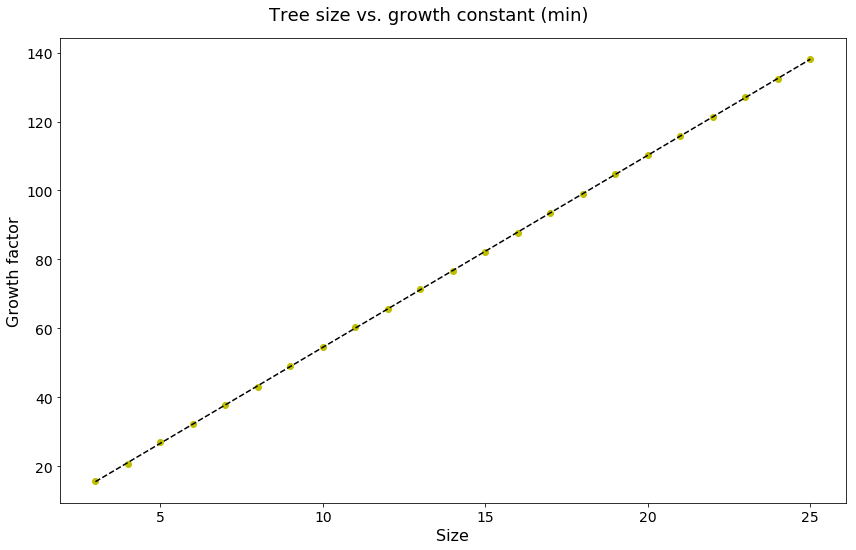

In [8]:
# All minimum growth factors, for all values of k
RESULTS_ASYMPTOTICS_UDL_MIN_GF = pd.DataFrame.from_dict({k: RESULTS_ASYMPTOTICS_UDL[UDL_MIN_GF[k]][k] for k in K_LIST}, orient='index')
# Fitting a line to the gowth factor for values of k for which the minimum tree size is given by a balanced tree
m_min,p_min = np.polyfit(np.array(K_LIST),np.array(RESULTS_ASYMPTOTICS_UDL_MIN_GF),1)
print('The line fitted to the minimum growth rate data points is the line '+str(m_min[0])+'*k'+str(p_min[0])+'.')

plt.figure(figsize=(12,8))
plt.plot(np.array(K_LIST),np.array(RESULTS_ASYMPTOTICS_UDL_MIN_GF), 'yo',np.array(K_LIST) , m_min*np.array(K_LIST)+p_min, '--k')
plt.suptitle('Tree size vs. growth constant (min)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Size', fontsize=16)
plt.ylabel('Growth factor', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures/Tree_size_vs_minGF_U_DL.png')
plt.show()

The polynomial fitted to the maximum growth rate data points is 0.4269778445553701*k^2+4.080528202957672*k-0.5501008397742587.


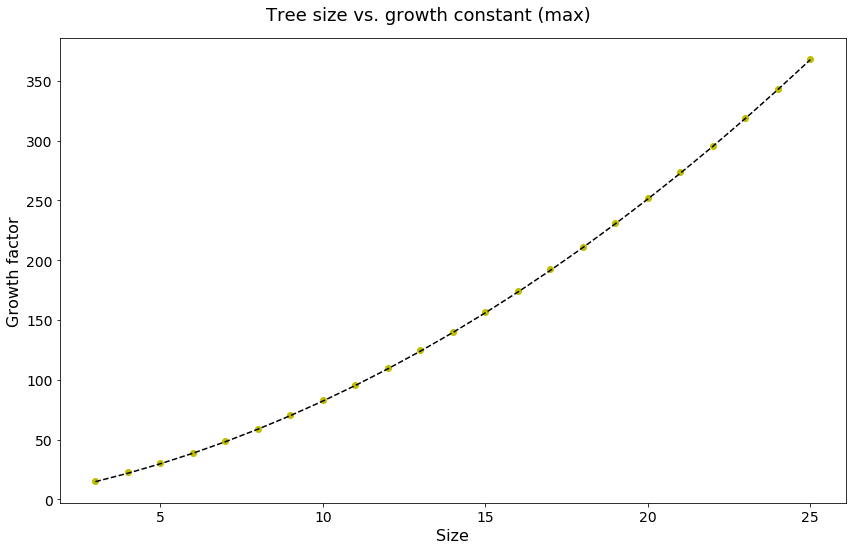

In [9]:
# All maximum growth factors, for all values of k
RESULTS_ASYMPTOTICS_UDL_MAX_GF = pd.DataFrame.from_dict({k: RESULTS_ASYMPTOTICS_UDL[UDL_MAX_GF[k]][k] for k in K_LIST}, orient='index')
# Fitting a degree 2 polynomial to the maximum growth factor
m1_max,m2_max,p_max = np.polyfit(np.array(K_LIST),np.array(RESULTS_ASYMPTOTICS_UDL_MAX_GF),2)
print('The polynomial fitted to the maximum growth rate data points is '+str(m1_max[0])+'*k^2+'+str(m2_max[0])+'*k'+str(p_max[0])+'.')

plt.figure(figsize=(12,8))
plt.plot(np.array(K_LIST),np.array(RESULTS_ASYMPTOTICS_UDL_MAX_GF), 'yo',np.array(K_LIST) , m1_max*np.array(K_LIST)*np.array(K_LIST)+m2_max*np.array(K_LIST)+p_min, '--k')
plt.suptitle('Tree size vs. growth constant (max)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Size', fontsize=16)
plt.ylabel('Growth factor', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figures/Tree_size_vs_maxGF_U_DL.png')
plt.show()

#### Discussion

We observe that for every value of $k$ the species tree with the maximum exponential growth factor is the caterpillar tree, and thet the growth factor grows quadratically as a function of $k$.

We also observe that for all values of $k$ for which the set of sampled species trees contains a balanced tree, the minimum growth factor is attained with a balanced tree. For these values of $k$ we can fit a line to the minimum growth factor, while for all other values of $k$ the minimum growth factor is above this line.

This set of observations supports conjecture 4.1 of the paper.

## Estimating the growth factor in an arbitrary model
We estimate the growth factor from the counting sequence using the formula
$$\alpha_S \simeq e^{\left(\frac{\ln\left(n^{3/2}h_S(n)\right)}{n}\right)}.$$

In [10]:
def estimate_growth_constant_1(m,k,n):
    RESULTS_COUNTING_m_k_n = [ ]
    RESULTS_COUNTING_m_k_n_aux = RESULTS_COUNTING.loc[(m,k,n)]
    for i in RESULTS_COUNTING_m_k_n_aux.keys():
        RESULTS_COUNTING_m_k_n += RESULTS_COUNTING_m_k_n_aux[i]
    RESULTS_COUNTING_m_k_n_EXP_GROWTH = []
    for c in RESULTS_COUNTING_m_k_n:
        RESULTS_COUNTING_m_k_n_EXP_GROWTH.append(math.exp(math.log(n*math.sqrt(n)*c)/n))
    return(RESULTS_COUNTING_m_k_n_EXP_GROWTH)

RESULTS_EST_ASYMPTOTICS_UDL  = pd.DataFrame({k: estimate_growth_constant_1(('U','DL'),k,50) for k in K_LIST})
RESULTS_EST_ASYMPTOTICS_RDL  = pd.DataFrame({k: estimate_growth_constant_1(('R','DL'),k,50) for k in K_LIST})
RESULTS_EST_ASYMPTOTICS_UDLT = pd.DataFrame({k: estimate_growth_constant_1(('U','DLT'),k,50) for k in K_LIST})
RESULTS_EST_ASYMPTOTICS_RDLT = pd.DataFrame({k: estimate_growth_constant_1(('R','DLT'),k,50) for k in K_LIST})

In [11]:
# Computing the ratio between the estimated and the exact growth constants
RATIO_RESULTS_ASYMPTOTICS_UDL = RESULTS_ASYMPTOTICS_UDL.transpose() / RESULTS_EST_ASYMPTOTICS_UDL 

<Figure size 432x288 with 0 Axes>

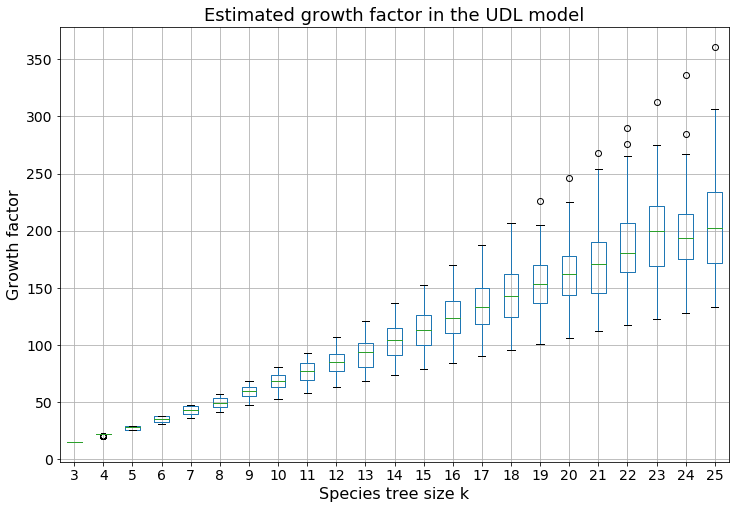

<Figure size 432x288 with 0 Axes>

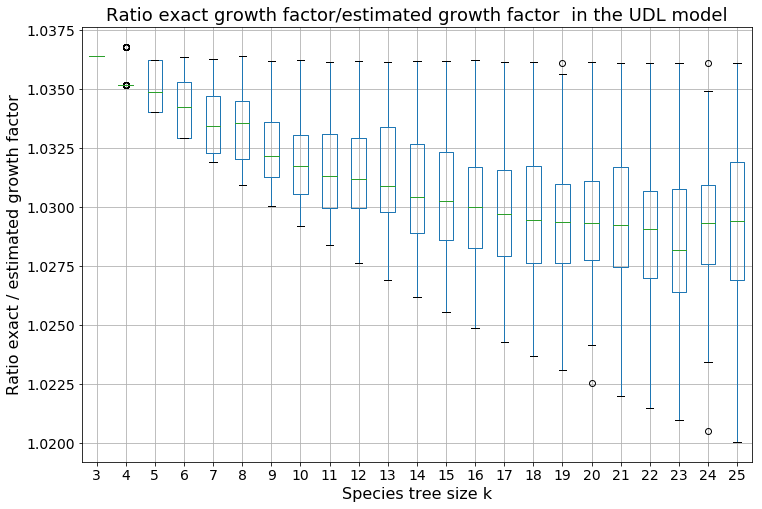

<Figure size 432x288 with 0 Axes>

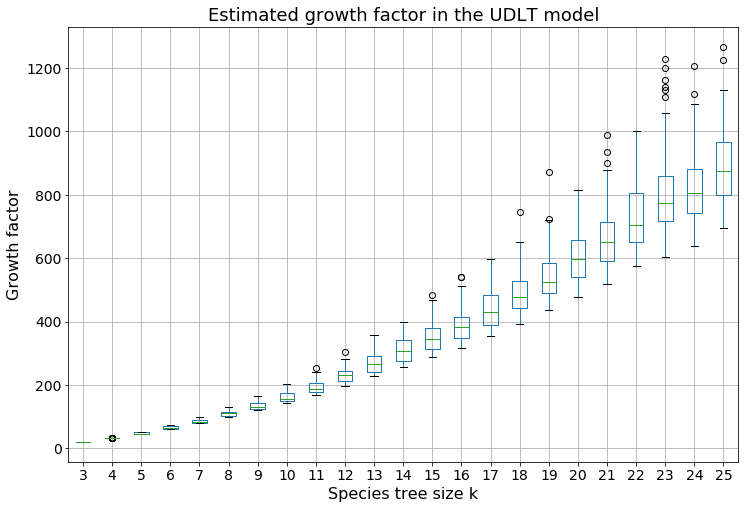

<Figure size 432x288 with 0 Axes>

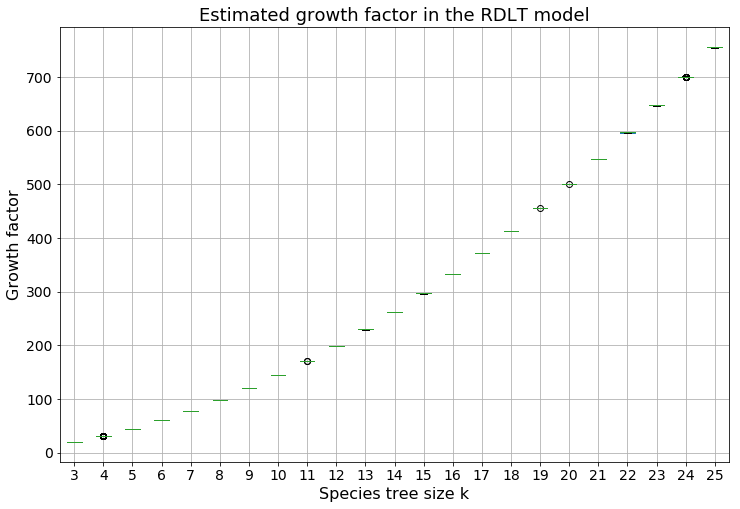

In [12]:
plt.figure()
ax_asympt4a = RESULTS_EST_ASYMPTOTICS_UDL.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Estimated growth factor in the UDL model', fontsize=14)
ax_asympt4a.title.set_size(18)
ax_asympt4a.set_ylabel('Growth factor', fontsize=16)
ax_asympt4a.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/estimated_growth_factor_U_DL.png')
plt.show()

plt.figure()
ax_asympt4aa = RATIO_RESULTS_ASYMPTOTICS_UDL.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Ratio exact growth factor/estimated growth factor  in the UDL model', fontsize=14)
ax_asympt4aa.title.set_size(18)
ax_asympt4aa.set_ylabel('Ratio exact / estimated growth factor', fontsize=16)
ax_asympt4aa.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/ratio_exact_estimated_growth_factor_U_DL.png')
plt.show()

plt.figure()
ax_asympt4b = RESULTS_EST_ASYMPTOTICS_UDLT.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Estimated growth factor in the UDLT model', fontsize=14)
ax_asympt4b.title.set_size(18)
ax_asympt4b.set_ylabel('Growth factor', fontsize=16)
ax_asympt4b.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/estimated_growth_factor_U_DLT.png')
plt.show()

plt.figure()
ax_asympt4c = RESULTS_EST_ASYMPTOTICS_RDLT.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Estimated growth factor in the RDLT model', fontsize=14)
ax_asympt4c.title.set_size(18)
ax_asympt4c.set_ylabel('Growth factor', fontsize=16)
ax_asympt4c.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('figures/estimated_growth_factor_R_DLT.png')
plt.show()

We can make a few observations. 

The first one is the very large increase of the estimated growth constant in the UDLT model compared to the UDL model.

The second one is that, when comparing the UDL and RDL models, the impact of the ranking is that it reduce the spread of the estimate growth constants.

Next we can observe that unlike in the UDL model, the mean and minimum growth rates seem to grow superlinearly.

Last, and extremely striking, in the RDLT model, the growth constant seems to almost not vary. It looks like in this model, the species tree topology does not matter much.

## Ratio DLT-histories / DL-histories

Last, we compute the ratio between the number of DLT-histories and the number of DL-histories in the ranked and unranked models.

In [13]:
RESULTS_aux = {k:{n:{t:0 for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            dlth = RESULTS_COUNTING.at[(('U','DLT'),k,n),t][0]
            dlh  = RESULTS_COUNTING.at[(('U','DL'),k,n),t][0]
            RESULTS_aux[k][n][t] = dlth/dlh
RATIOS_UDLT_UDL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

RESULTS_aux = {k:{n:{(t,r): 0 for r in R_LIST for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            for r in R_LIST:
                dlth = RESULTS_COUNTING.at[(('R','DLT'),k,n),t][r-1]
                dlh  = RESULTS_COUNTING.at[(('R','DL'),k,n),t][r-1]
                RESULTS_aux[k][n][(t,r)] = dlth/dlh
RATIOS_RDLT_RDL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

<Figure size 432x288 with 0 Axes>

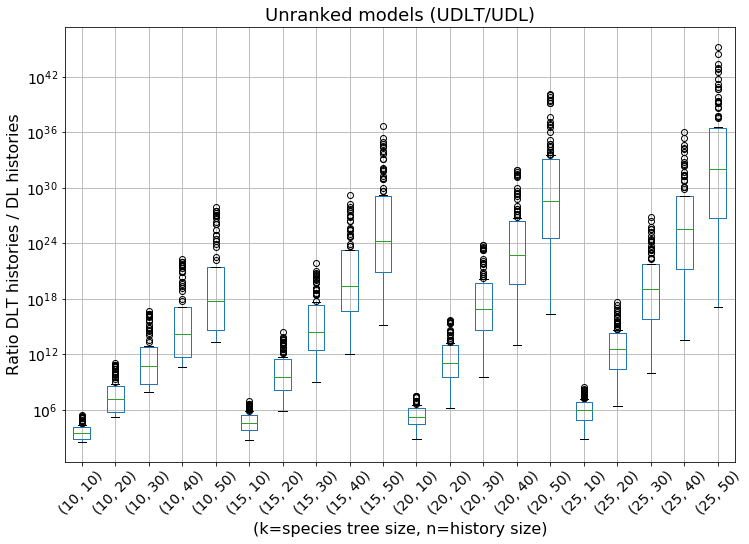

<Figure size 432x288 with 0 Axes>

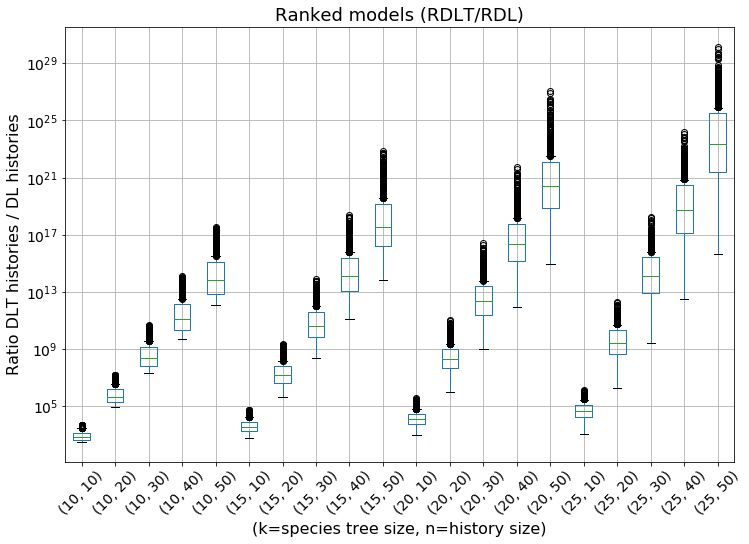

In [14]:
plt.figure()
ax_ratio1a = RATIOS_UDLT_UDL.transpose().plot(kind='box', grid=True, figsize=(12,8), return_type='axes', title='Unranked models (UDLT/UDL)', fontsize=14)
ax_ratio1a.title.set_size(18)
ax_ratio1a.set_yscale('log')
ax_ratio1a.set_ylabel('Ratio DLT histories / DL histories', fontsize=16)
plt.xticks(rotation=45)
ax_ratio1a.set_xlabel('(k=species tree size, n=history size)', fontsize=16)
plt.savefig('figures/ratio_UDLT_UDL_per_tree.png')
plt.show()

plt.figure()
ax_ratio1b = RATIOS_RDLT_RDL.transpose().plot(kind='box', grid=True, figsize=(12,8), return_type='axes', title='Ranked models (RDLT/RDL)', fontsize=14)
ax_ratio1b.title.set_size(18)
ax_ratio1b.set_yscale('log')
ax_ratio1b.set_ylabel('Ratio DLT histories / DL histories', fontsize=16)
plt.xticks(rotation=45)
ax_ratio1b.set_xlabel('(k=species tree size, n=history size)', fontsize=16)
plt.savefig('figures/ratio_RDLT_RDL_per_tree.png')
plt.show()

We can observe again the impact of adding transfers in a model, that results in a large increase of the number of histories.

## Score distribution from sampling

For each of the htree models UDL, UDLT, RDLT, we considered $(k,n)=(8,10),(8,15),(16,20),(16,30)$ and for each parameter setting we generated 5 random species trees (plus ranking in the RDLT model) and $10,000$ random histories. We show the distribution of the number of duplications, losses, HGTs and score (defined as the sum of the three kinds of events).

In [15]:
def read_scores(k,n,m,s):
    RESULTS_SCORES_aux  = {}
    with gzip.open(PREFIX_SCORES+'_'+str(k)+'_'+str(n)+'_'+m+'.gz', 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0] == '#': #Species tree
                treeIndex = int(row[0].replace('# S_',''))
                RESULTS_SCORES_aux[treeIndex]  = {'D':[], 'L':[], 'T':[], 'A':[]}
                sampleIndex = 0
            else:
                row1 = row[0].rstrip().split(' ')
                D = int(row1[k].split(':')[1])
                L = int(row1[k+1].split(':')[1])
                T = int(row1[k+2].split(':')[1])
                RESULTS_SCORES_aux[treeIndex]['D'].append(D)
                RESULTS_SCORES_aux[treeIndex]['L'].append(L)
                RESULTS_SCORES_aux[treeIndex]['T'].append(T)
                RESULTS_SCORES_aux[treeIndex]['A'].append(D+L+T)
                sampleIndex += 1
                
    RESULTS_SCORES = pd.DataFrame.from_dict({(t): RESULTS_SCORES_aux[t]
                                            for t in RESULTS_SCORES_aux.keys()},
                                            orient='index')
    return(RESULTS_SCORES)

In [68]:
SCORES_16_30_UDL  = read_scores(16,30,'UDL',10000)
SCORES_16_30_UDLT = read_scores(16,30,'UDLT',10000)

<Figure size 432x288 with 0 Axes>

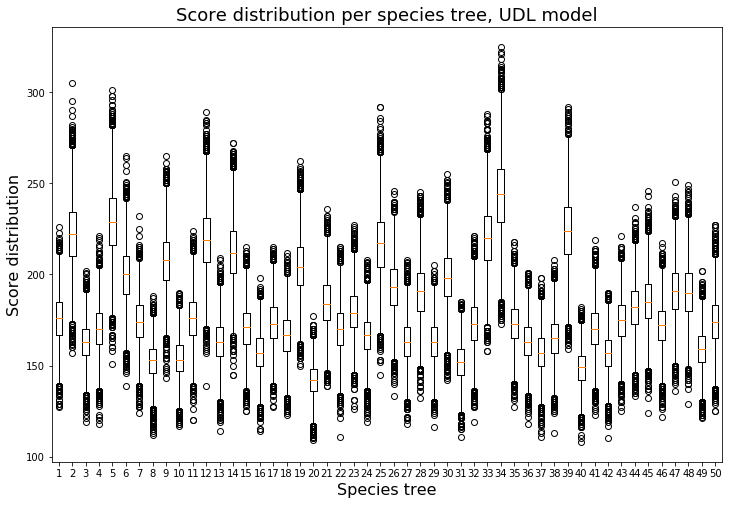

<Figure size 432x288 with 0 Axes>

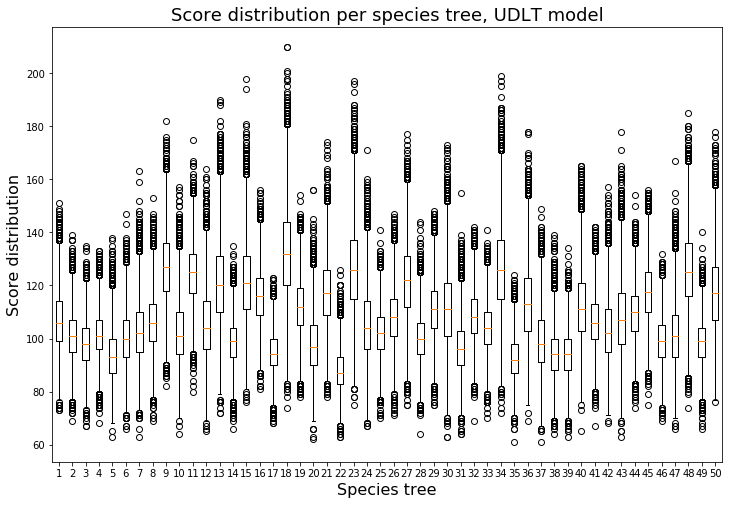

In [18]:
# Score distribution UDL, UDLT, RDLT

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Score distribution per species tree, UDL model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDL['A']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Score distribution', fontsize=16)
plt.savefig('figures/scores_16_30_UDL.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Score distribution per species tree, UDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDLT['A']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Score distribution', fontsize=16)
plt.savefig('figures/scores_16_30_UDLT.png')
plt.show()

<Figure size 432x288 with 0 Axes>

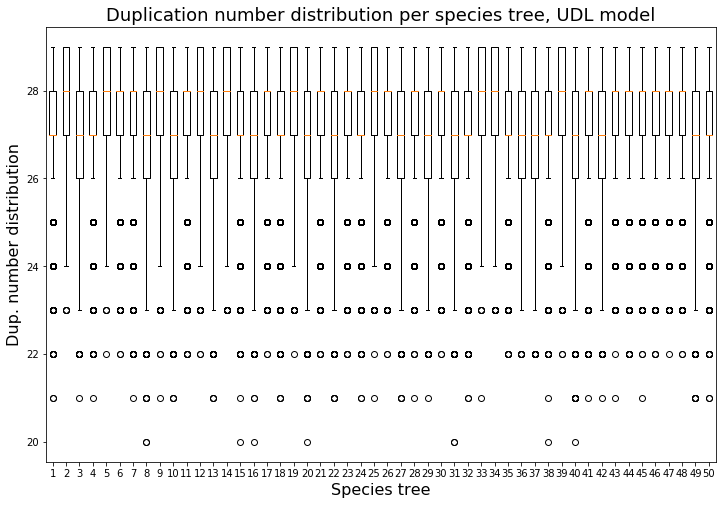

<Figure size 432x288 with 0 Axes>

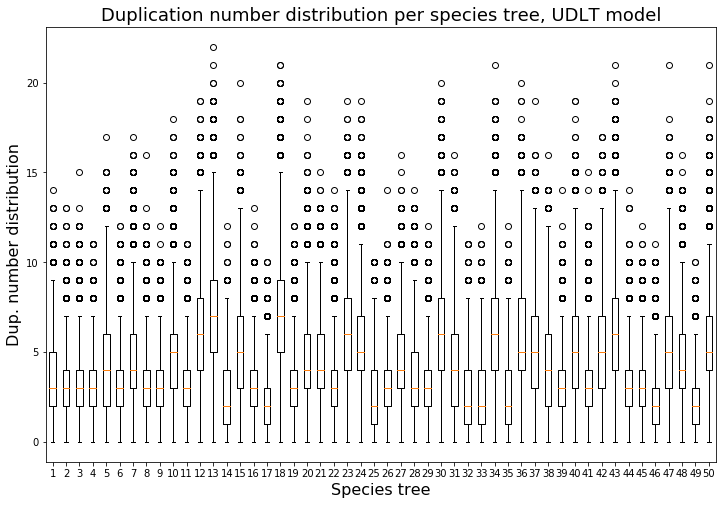

<Figure size 432x288 with 0 Axes>

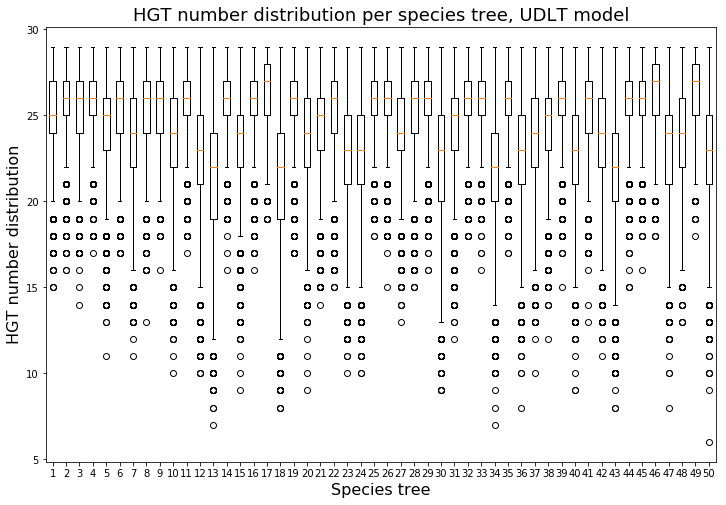

In [20]:
# Duplications/HGTs distribution UDL, UDLT, RDLT

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Duplication number distribution per species tree, UDL model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDL['D']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Dup. number distribution', fontsize=16)
plt.savefig('figures/duplications_16_30_UDL.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Duplication number distribution per species tree, UDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDLT['D']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Dup. number distribution', fontsize=16)
plt.savefig('figures/duplications_16_30_UDLT.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('HGT number distribution per species tree, UDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDLT['T']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('HGT number distribution', fontsize=16)
plt.savefig('figures/HGT_16_30_UDLT.png')
plt.show()

We now look at how the different evolutionary events behave in the samples histories. Precisely, we look at the following ratios:
- duplications versus score in the UDL-model and UDLT-model,
- HGT versus score in the UDLT-model,
- duplications versus HGT in the UDLT-model.

In [94]:
from operator import truediv 

RATIO_DUP_SCORE_UDL = []
RATIO_DUP_SCORE_UDLT = []
RATIO_HGT_SCORE_UDLT = []
RATIO_DUP_HGT_UDLT = []

UDL_NBTREES = len(SCORES_16_30_UDL)
for t in range(UDL_NBTREES):
    RATIO_DUP_SCORE_UDL  += list(map(truediv,SCORES_16_30_UDL.iloc[t]['D'],SCORES_16_30_UDL.iloc[t]['A']))

UDLT_NBTREES = len(SCORES_16_30_UDL)
for t in range(UDLT_NBTREES):
    RATIO_DUP_SCORE_UDLT += list(map(truediv,SCORES_16_30_UDLT.iloc[t]['D'],SCORES_16_30_UDLT.iloc[t]['A']))
    RATIO_HGT_SCORE_UDLT += list(map(truediv,SCORES_16_30_UDLT.iloc[t]['T'],SCORES_16_30_UDLT.iloc[t]['A']))
    RATIO_DUP_HGT_UDLT   += list(map(truediv,SCORES_16_30_UDLT.iloc[t]['D'],SCORES_16_30_UDLT.iloc[t]['T']))
    
NB_BINS = 21 # Number of histograms bins

<Figure size 432x288 with 0 Axes>

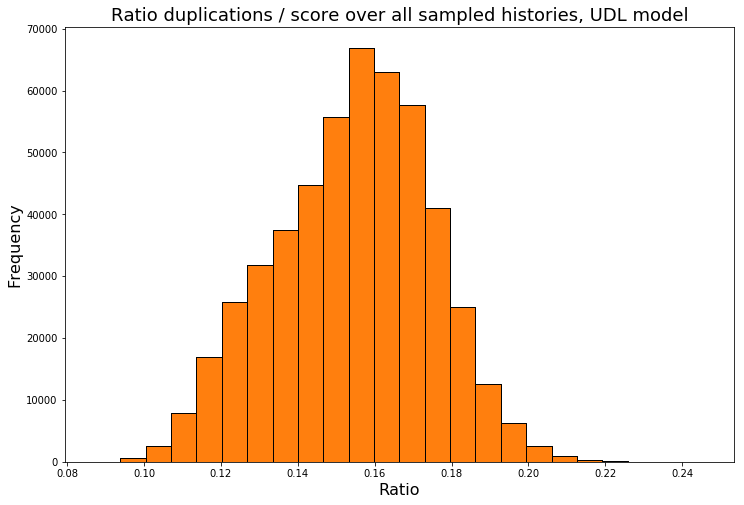

In [77]:
bins_DUP_SCORE_UDL = np.linspace(min(RATIO_DUP_SCORE_UDL), 
                                 max(RATIO_DUP_SCORE_UDL),
                                 NB_BINS)
plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Ratio duplications / score over all sampled histories, UDL model', fontsize=14)
_ = plt.hist(RATIO_DUP_SCORE_UDL, bins=bins_DUP_SCORE_UDL, ec='black', color='darkorange') 
ax.title.set_size(18)
ax.set_xlabel('Ratio', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
plt.savefig('figures/duplications_vs_score_16_30_UDL.png')
plt.hist(RATIO_DUP_SCORE_UDL, bins=bins_DUP_SCORE_UDL, ec='black')
plt.show()

<Figure size 432x288 with 0 Axes>

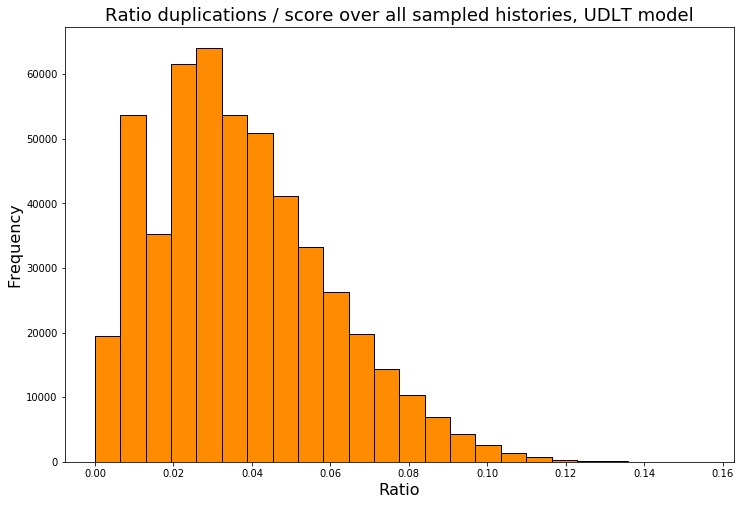

In [81]:
bins_DUP_SCORE_UDLT = np.linspace(min(RATIO_DUP_SCORE_UDLT), 
                                  max(RATIO_DUP_SCORE_UDLT),
                                  NB_BINS)
plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Ratio duplications / score over all sampled histories, UDLT model', fontsize=14)
_ = plt.hist(RATIO_DUP_SCORE_UDLT, bins=bins_DUP_SCORE_UDLT, ec='black', color='darkorange') 
ax.title.set_size(18)
ax.set_xlabel('Ratio', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
plt.savefig('figures/duplications_vs_score_16_30_UDLT.png')
plt.show()

<Figure size 432x288 with 0 Axes>

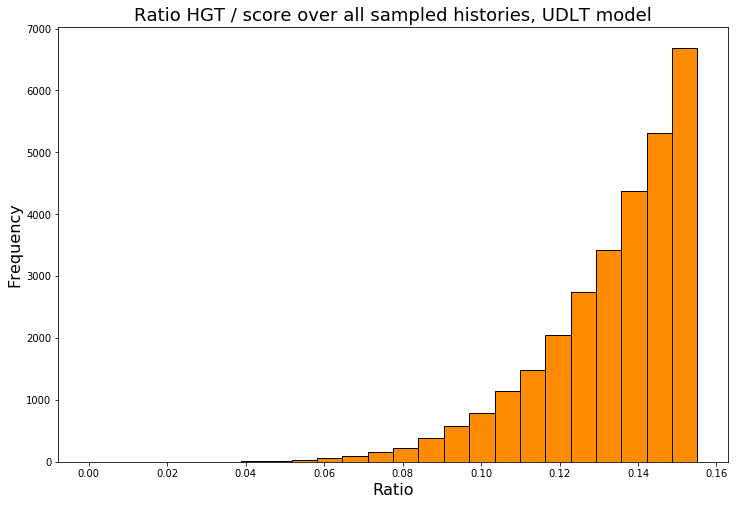

In [99]:
bins_HGT_SCORE_UDLT = np.linspace(min(RATIO_HGT_SCORE_UDLT), 
                                  max(RATIO_HGT_SCORE_UDLT),
                                  NB_BINS)

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Ratio HGT / score over all sampled histories, UDLT model', fontsize=14)
_ = plt.hist(RATIO_HGT_SCORE_UDLT, bins=bins_DUP_SCORE_UDLT, ec='black', color='darkorange') 
ax.title.set_size(18)
ax.set_xlabel('Ratio', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
plt.savefig('figures/HGT_vs_score_16_30_UDLT.png')
plt.show()

<Figure size 432x288 with 0 Axes>

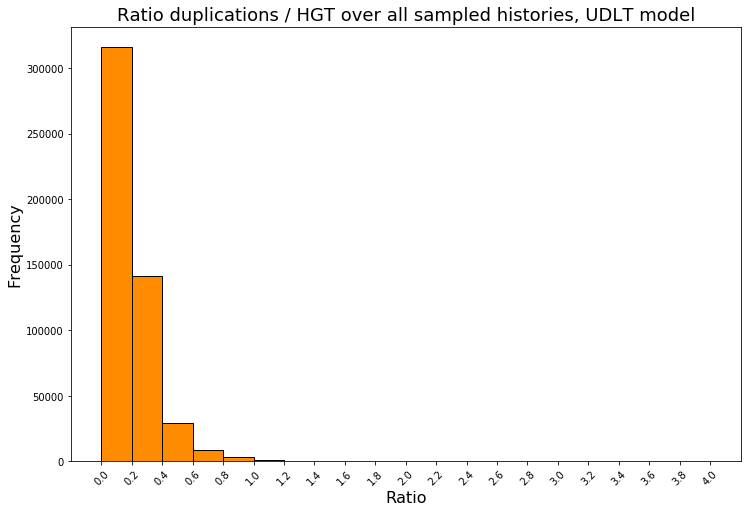

In [95]:
bins_DUP_HGT_UDLT = np.linspace(math.floor(min(RATIO_DUP_HGT_UDLT)), 
                                math.ceil(max(RATIO_DUP_HGT_UDLT)),
                                21)
plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Ratio duplications / HGT over all sampled histories, UDLT model', fontsize=14)
_ = plt.hist(RATIO_DUP_HGT_UDLT, bins=bins_DUP_HGT_UDLT, ec='black', color='darkorange') 
ax.title.set_size(18)
plt.xticks(bins_DUP_HGT_UDLT, rotation=45)
ax.set_xlabel('Ratio', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
plt.savefig('figures/HGT_vs_score_16_30_UDLT.png')
plt.show()